In [1]:
notebook_id = 901

<a id="ID_top"></a>
## Map generator | BRI map

Raw data source [here](https://www.naturalearthdata.com/downloads/50m-cultural-vectors/)
Code inspiration [here](https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0)
Nice diagram for panda merge [here](https://medium.com/swlh/merging-dataframes-with-pandas-pd-merge-7764c7e2d46d), example code [here](http://www.datasciencemadesimple.com/join-merge-data-frames-pandas-python/)

Useful guide on categorical mapping with geopands [here](https://dmnfarrell.github.io/plotting/categorical-geopandas-maps)


Using geopandas and natural earth shape file to plot a world map with countries highlighted based on 3 digit iso code.

In [2]:
#![Image of Joins](https://miro.medium.com/max/1400/1*9eH1_7VbTZPZd9jBiGIyNA.png)

#### Notebook sections:
    
|| [0| Default imports](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

#### Import all packages that could be required

In [3]:
# %load s_package_import.py
# package library, use to ensure consistency across notebooks, refresh periodically
# general packages
import os # use with os.listdir(_path_)
import requests
import csv
import time
from datetime import datetime
from shutil import copyfile

#temp check
#from shutil import make_archive
#import zipfile

# data analysis packages
import pandas as pd
pd.options.display.max_columns = None # don't truncate columns
#pd.options.display.max_rows = None

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes

# custom scripts
import s_file_export
import s_filepaths
import s_un_comtrade_extract as s_un
import s_adj_matrix_plot

#=== network analysis
import networkx as nx
#=== gavity modelling
#import gme as gme


#### Import module and declare path variables
`import s_filepaths.py`

In [4]:
# import ref file
import s_filepaths

# declare local variables to work with
path_raw = s_filepaths.path_raw
path_raw_dl = s_filepaths.path_raw_dl
path_store = s_filepaths.path_store
path_live = s_filepaths.path_live
path_map = s_filepaths.path_map
path_image = s_filepaths.path_images

<a id="ID_part1"></a>
### Part 1 | Import map data
|| [0| Default imports](#ID_top) || [1|Part1 Import data](#ID_part1) || [2|Part2 Load BRI data](#ID_part2) || [3|Part3 Merge, prep, visualise](#ID_part3) || 

In [5]:
os.listdir(f"{path_map}ne_50m_admin_0_countries")

['ne_50m_admin_0_countries.VERSION.txt',
 'ne_50m_admin_0_countries.prj',
 'ne_50m_admin_0_countries.README.html',
 'ne_50m_admin_0_countries.dbf',
 'ne_50m_admin_0_countries.shp',
 'ne_50m_admin_0_countries.cpg',
 'ne_50m_admin_0_countries.shx']

In [6]:
# file path
base_shape_file = f"{path_map}ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"

# geopandas dataframe
gdf_map = gpd.read_file(base_shape_file)[["ADM0_A3","ADMIN","geometry"]]
gdf_map.columns = ["iso_3","country_name","geometry"]

In [7]:
gdf_map.head()

,iso_3,country_name,geometry
0,ZWE,Zimbabwe,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,ZMB,Zambia,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,YEM,Yemen,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."
3,VNM,Vietnam,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ..."
4,VEN,Venezuela,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9..."


<a id="ID_part2"></a>
### Part 2 | Desired iso3 list
|| [0| Default imports](#ID_top) || [1|Part1 Import data](#ID_part1) || [2|Part2 Load BRI data](#ID_part2) || [3|Part3 Merge, prep, visualise](#ID_part3) || 

In [8]:
print(os.listdir(f"{path_live}"))

['121_input_di_matrix.csv.gzip', '.DS_Store', '121_input_de_min_max.csv.gzip', '112_input_gme_data.csv.gzip', '125_input_scope_country.csv.gzip', '121_input_lpi_matrix.csv.gzip', '122_input_un_com_2016_mini.csv.gzip', '120_input_scope_data.csv.gzip', '2_raw_explainer_doc.md', '121_input_de_matrix.csv.gzip', '113_input_bri_members.csv.gzip', '121_input_di_min_max.csv.gzip']


In [9]:
df_data_in = pd.read_csv(f"{path_live}125_input_scope_country.csv.gzip",compression = "gzip")

In [10]:
df_data_in.head()

,year,country_d,iso3_d,dynamic_code_d,landlocked_d,island_d,region_d,gdp_pwt_const_d,pop_d,lat_d,lng_d,country_o,iso3_o,dynamic_code_o,landlocked_o,island_o,region_o,pop_o,lat_o,lng_o,contiguity,distance,bri_year_d,bri_flag_d,economic_distance,institutional_distance,logistics,logistics_geo_distance,Import_value,rtCode,rt3ISO,ptCode,pt3ISO,Export_value
0,2016,United Arab Emirates,ARE,ARE,0,0,middle_east,NaN,NaN,25.094378,55.454674,Portugal,PRT,PRT,0,0,europe,NaN,39.310741,-10.883486,0,6154.4214,2017.0,1.0,32364.307560,0.403792,1.331108,8192.201100,2.183510e+08,620.0,PRT,784.0,ARE,1.794034e+08
1,2016,Belgium,BEL,BEL,0,0,europe,NaN,NaN,50.691814,4.581812,Cambodia,KHM,KHM,0,0,south_east_asia,NaN,12.320902,104.874400,0,9693.0625,NaN,NaN,44933.919861,4.775302,1.386359,13438.064434,3.670375e+08,116.0,KHM,56.0,BEL,3.968047e+08
2,2016,China,CHN,CHN,0,0,east_asia,NaN,NaN,35.389668,114.002470,Belarus,BLR,BLR,1,0,europe,NaN,53.604687,27.802185,0,6904.3364,2013.0,1.0,4153.131454,0.004938,1.492458,10304.432095,4.351889e+08,112.0,BLR,156.0,CHN,4.005118e+08
3,2016,Spain,ESP,ESP,0,0,europe,NaN,NaN,39.231297,-4.263840,Belgium,BEL,BEL,0,0,europe,NaN,50.691814,4.581812,0,1374.9351,NaN,NaN,11326.515268,1.841935,1.270506,1746.863638,7.757618e+09,56.0,BEL,724.0,ESP,1.049398e+10
4,2016,Georgia,GEO,GEO,0,0,europe,NaN,NaN,42.079079,42.981064,Iran,IRN,IRN,0,0,middle_east,NaN,33.925423,52.192562,0,1097.2799,2016.0,1.0,1153.061729,2.290772,1.630717,1789.352575,8.445334e+07,364.0,IRN,268.0,GEO,7.591084e+07


In [18]:
df_plot = df_data_in.loc[:,["year","iso3_d"]].copy()
df_plot = df_plot.drop_duplicates().copy()
df_plot.columns = ["year","iso_3"]
df_plot["Plot"] = 1
df_plot["Label"] = "Country in scope"

In [12]:
print(df_plot.shape)
df_plot.head()

(70, 4)


,year,iso_3,Plot,Label
0,2016,ARE,1,Country in scope
1,2016,BEL,1,Country in scope
2,2016,CHN,1,Country in scope
3,2016,ESP,1,Country in scope
4,2016,GEO,1,Country in scope


<a id="ID_part3"></a>
### Part 3 | Merge and prep data
|| [0| Default imports](#ID_top) || [1|Part1 Import data](#ID_part1) || [2|Part2 Load BRI data](#ID_part2) || [3|Part3 Merge, prep, visualise](#ID_part3) || 

In [19]:
gdf_map_merged = gdf_map.merge(df_plot, on = "iso_3",how = "left",copy = False)
print(gdf_map_merged.shape)

(241, 6)


In [20]:
# Colour column
colour_series = []

for entry in list(gdf_map_merged.Plot):
    
    if entry == 1:
        colour_series.append("#aa381e")
    else:
        colour_series.append("white")

gdf_map_merged["colour"] = colour_series
gdf_map_merged.head()

,iso_3,country_name,geometry,year,Plot,Label,colour
0,ZWE,Zimbabwe,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344...",NaN,NaN,NaN,white
1,ZMB,Zambia,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643...",NaN,NaN,NaN,white
2,YEM,Yemen,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16...",NaN,NaN,NaN,white
3,VNM,Vietnam,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ...",2016.0,1.0,Country in scope,#aa381e
4,VEN,Venezuela,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9...",NaN,NaN,NaN,white


In [25]:
gdf_map_merged.Label.unique()

array([nan, 'Country in scope'], dtype=object)

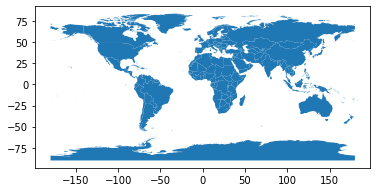

In [21]:
# sample plot
gdf_map_merged.plot()

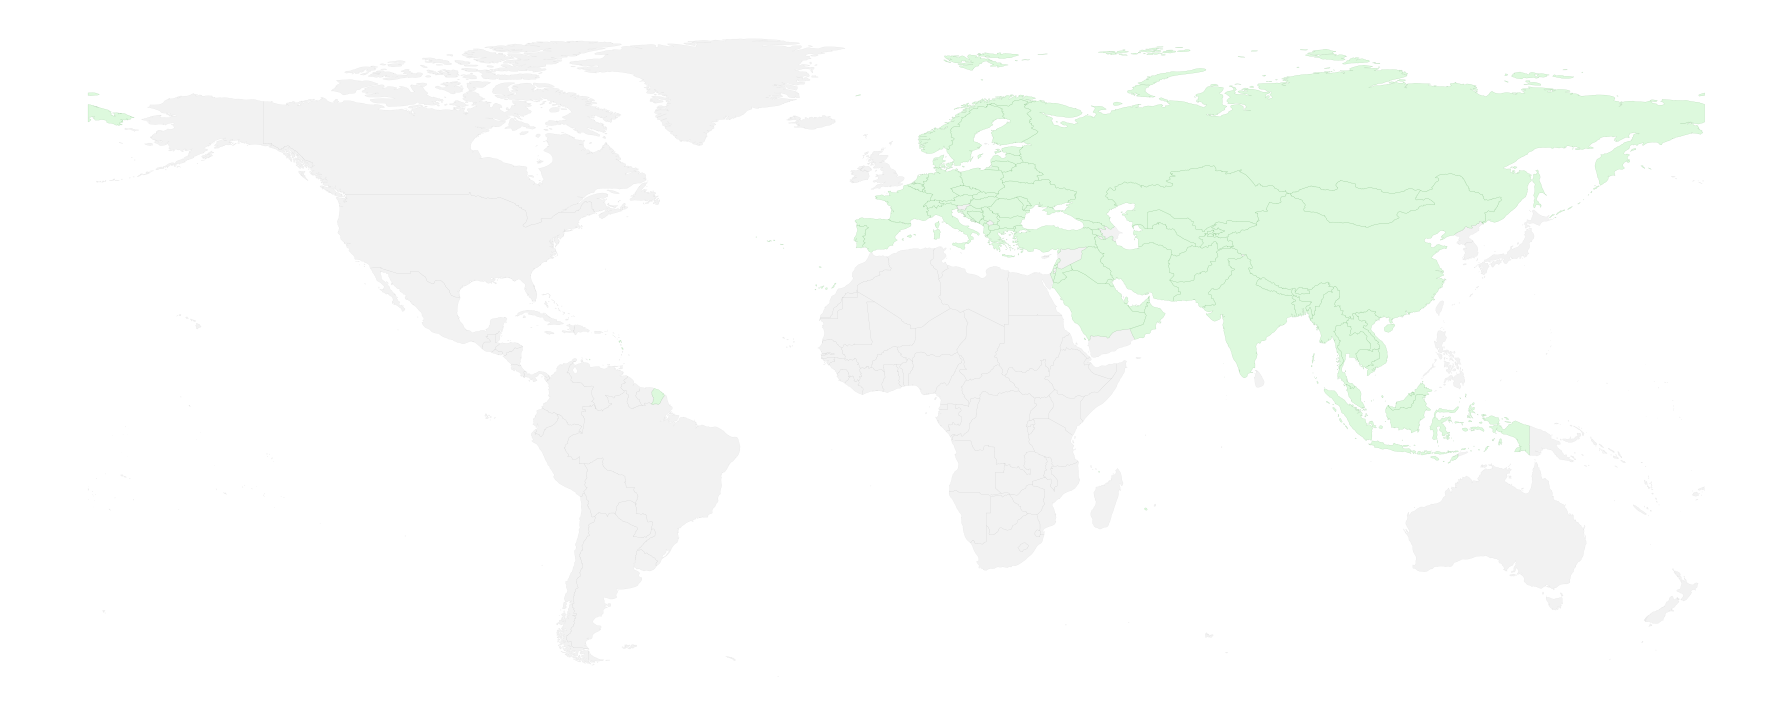

In [56]:
# dataframe to feed plot
gdf_plot = gdf_map_merged[(gdf_map_merged.country_name!="Antarctica")].copy()
number_categories = 1#len(gdf_plot.Label.unique())

# Plotting # define number of bins we want from cmap
fig, ax_bri = plt.subplots(1, figsize=(25,20))

gdf_plot[(gdf_plot.Label == "Country in scope")].plot(color = "lightgreen", 
                                                      alpha = 0.3,linewidth = 0.2,
                                                      edgecolor = "darkgreen", 
                                                      label = "In scope countries",
                                                      legend= True,ax = ax_bri)
gdf_plot[(gdf_plot.Label != "Country in scope")].plot(color = "gray", alpha = 0.1,
                                                      linewidth = 0.2,
                                                      edgecolor = "black",
                                                      label = "Out of scope countries",
                                                      legend= True,ax = ax_bri)

# Final customisation (map axis, title and layout padding)
ax_bri.axis('off')
ax_bri.set_title("",fontsize=30)
plt.tight_layout()

# Save image
keyword = "_no_labels"
fig.savefig(f"{path_image}{notebook_id}_scope_map{keyword}.png",dpi=500)